# chemical maps

This notebooks has simple workflows with chemical X-ray data obtained with an electron probe microanalyzer (EMPA), with both EDS (energy-dispersive) and WDS (wavelength-dispersive) spectometers. 

Data is from a high-grade _crd-grt granulite with spl-sill_ from the **Araçuaí Orogen**, SE Brazil. Full description of this sample is described by Schiavetti _et al._ (2025).

Worklows are:
* load and display individual X-ray maps
* train a machine-learning model to classify minerals
* load mineral chemistry standards and use a cluster algorithm to classify all pixels

Classes
* XrayMap

---

to do
* read and review
* setup analysis


#### setup

In [1]:
# importing libs
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# utils
from src.xraymap import XrayMap # map Class
from src.utils import get_dirs # function that reads directories

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

In [2]:
# loading dirs that might be used
get_dirs()

{'SOURCE_DIR': '/home/orogen/code/xmapy',
 'DATA_DIR': '/home/orogen/code/xmapy/data',
 'FIGS_DIR': '/home/orogen/code/xmapy/figs',
 'QUERY_DIR': '/home/orogen/code/xmapy/queries',
 'PLOT_DIR': '/home/orogen/code/xmapy/plots'}

In [3]:
# setting up plots
plt.rcParams["figure.figsize"] = (16,8)

### analysis

In [4]:
# using Al as an example

element = "Al"
al_map = XrayMap(element=element)
print("We created: ", al_map, "!")

Al.csv found!
We created:  <src.xraymap.XrayMap object at 0x7ff967fdbef0> !


Al


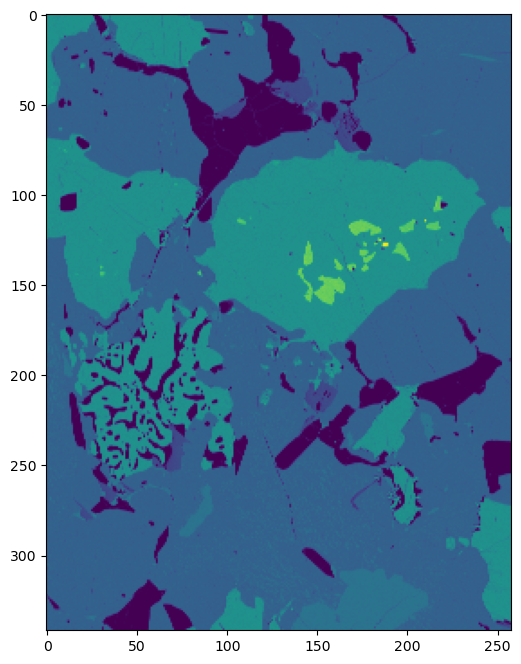

In [5]:
al_map.show_map()

**loading specific maps using our class**

* loading all maps

In [6]:
# load X-Ray maps

def load_maps(elements):
 
  maps = []
  for el in elements:
    try:
      # print('{a}.csv'.format(a=el))
      map_el = XrayMap(element=el)
      maps.append(map_el)
    
    except:
      print("error loading map")
  
  for x in maps:
    x.xray_data = x.data.to_numpy().astype(np.float32) / 255.0

  return maps

In [7]:
ELEMENTS = ["Al","Ba","Ca","Cl","Cr","Fe","K","Mg","Mn","Mn","Na","P","S","Si","Ti","Zn","Zr"]
all_maps = load_maps(ELEMENTS)

Al.csv found!
Ba.csv found!
Ca.csv found!
Cl.csv found!
Cr.csv found!
Fe.csv found!
K.csv found!
Mg.csv found!
Mn.csv found!
Mn.csv found!
Na.csv found!
P.csv found!
S.csv found!
Si.csv found!
Ti.csv found!
Zn.csv found!
Zr.csv found!


Fe


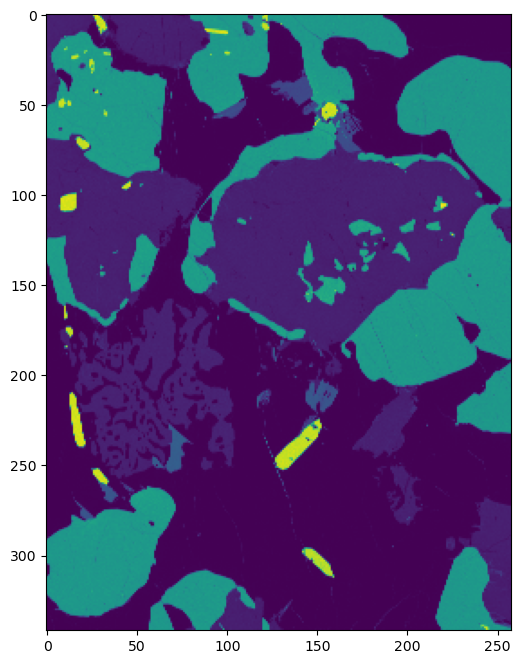

In [8]:
all_maps[5].show_map()

### Machine Learning

#### A | classifying a mineral based on the information from sample pixels

rationale:
* with X-ray maps, we can stack information and get a combination of intesities for each pixel
* then, isolating pixels from a specific minera, e.g. garnet, we can model all other pixels

#### sample

In [9]:
df_Al = XrayMap(element="Al")
df_Fe = XrayMap(element="Fe")
df_Si = XrayMap(element="Si")
df_Mg = XrayMap(element="Mg")

# true_Grt = XrayMap(element="true_Grt")

# true_Grt = pd.read_csv(os.path.join(get_dirs()["DATA_DIR"], "trueGrt.csv"))

Al.csv found!
Fe.csv found!
Si.csv found!
Mg.csv found!


In [10]:
df_Al.data.describe()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
count,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,...,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0,342.0
mean,4558.353801,4526.511696,4522.964912,4476.140351,4391.260234,4361.073099,4311.040936,4225.391813,4084.350877,4083.195906,...,3820.309942,3836.187135,3894.166667,3970.628655,3991.815789,4031.959064,4064.821637,4085.979532,4086.160819,4100.28655
std,1095.84777,1102.623802,1115.444497,1114.42583,1128.700854,1066.868025,1019.677566,1006.759576,1176.827464,1205.166687,...,1630.445609,1578.125764,1580.525668,1498.952455,1445.982,1425.554007,1402.42738,1428.789181,1413.291533,1423.394911
min,1960.0,1228.0,50.0,25.0,33.0,30.0,50.0,19.0,12.0,20.0,...,15.0,15.0,18.0,20.0,18.0,15.0,18.0,16.0,17.0,18.0
25%,3777.0,3763.25,3774.0,3760.0,3742.75,3758.0,3750.0,3746.0,3726.5,3723.5,...,3693.0,3689.25,3700.25,3700.25,3698.25,3702.0,3711.25,3698.25,3706.0,3706.25
50%,3874.0,3860.0,3863.5,3856.0,3830.5,3823.0,3827.0,3812.5,3790.5,3784.0,...,3760.0,3752.0,3770.0,3760.5,3759.0,3766.0,3764.0,3765.5,3774.5,3763.0
75%,6064.0,6080.0,6047.0,6006.25,5948.0,5464.5,4155.25,4119.25,3957.5,3951.0,...,3868.75,3836.5,3869.0,3896.25,3870.25,3865.0,3879.25,3915.5,4047.25,4098.5
max,6378.0,6403.0,6392.0,6793.0,6342.0,6275.0,6326.0,6818.0,6357.0,6579.0,...,6335.0,6249.0,6298.0,6342.0,6390.0,6360.0,6271.0,6310.0,6298.0,6373.0


In [11]:
df_Al.dimensions

(342, 258)

(342, 258)


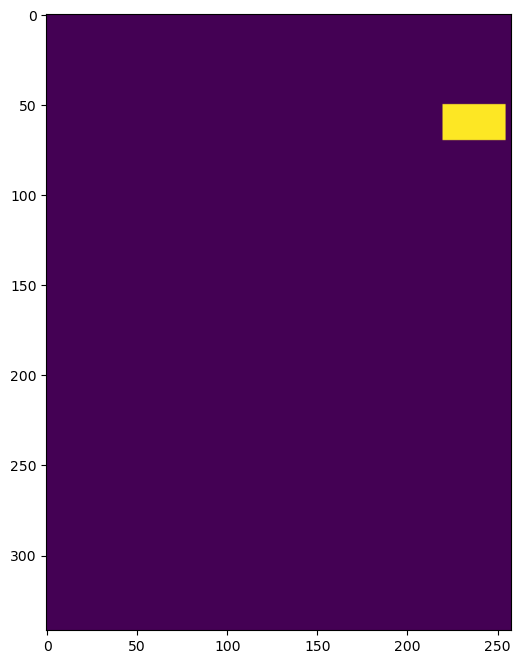

In [12]:
true_grt = np.zeros(df_Al.dimensions)
print(true_grt.shape)
true_grt[50:70,220:255] = 1

plt.imshow(true_grt)

In [13]:
for df in [df_Al, df_Fe, df_Si, df_Mg, true_grt]: 
  print(df.data.shape)

(342, 258)
(342, 258)
(342, 258)
(342, 258)
(342, 258)


In [14]:
df_composition = np.stack([df_Al.data, df_Fe.data, df_Mg.data, df_Si.data, true_grt], axis=-1)
print(df_composition.shape)

(342, 258, 5)


In [15]:
df_good = pd.DataFrame(df_composition.reshape(-1, df_composition.shape[-1]), columns=["Al","Fe","Mg","Si", "flGrt"])
df_good_labeled = df_good[df_good.flGrt == 1]

* modelling

In [16]:
X = df_good_labeled[["Al", "Fe", "Mg", "Si"]]
y = df_good_labeled["flGrt"].astype(int)

model = LogisticRegression()
model_forest = IsolationForest()
model_forest.fit(X)

IsolationForest()

In [17]:
df_to_predict = df_good.drop(columns=["flGrt"], inplace=False)

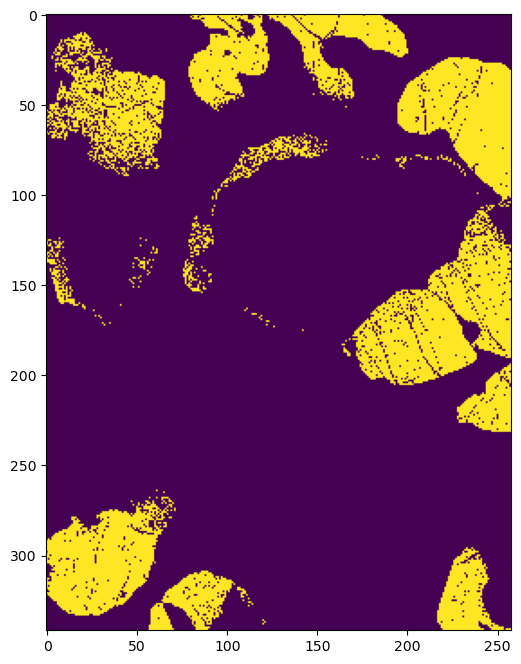

In [18]:
plt.imshow(model_forest.predict(df_to_predict).reshape(342, 258))

### Working with Resolutions

Test the following solutions:
* opencv `resize`
* scikit-image
* grainsight / FastSAM
* PetroSeg


In [33]:
import cv2

Al


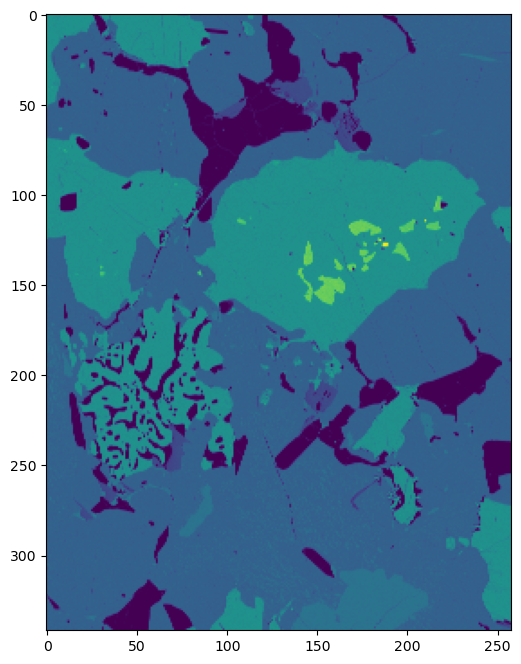

In [20]:
al_map.show_map()

In [35]:
fe_bigger = XrayMap("Fe_bigger")

Fe_bigger.csv found!


Fe_bigger


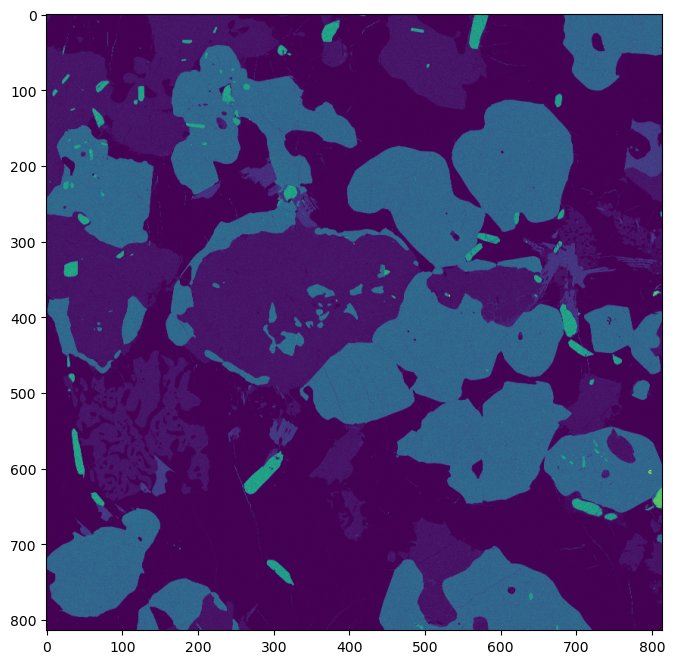

In [36]:
fe_bigger.show_map()

In [21]:
al_map.dimensions

(342, 258)

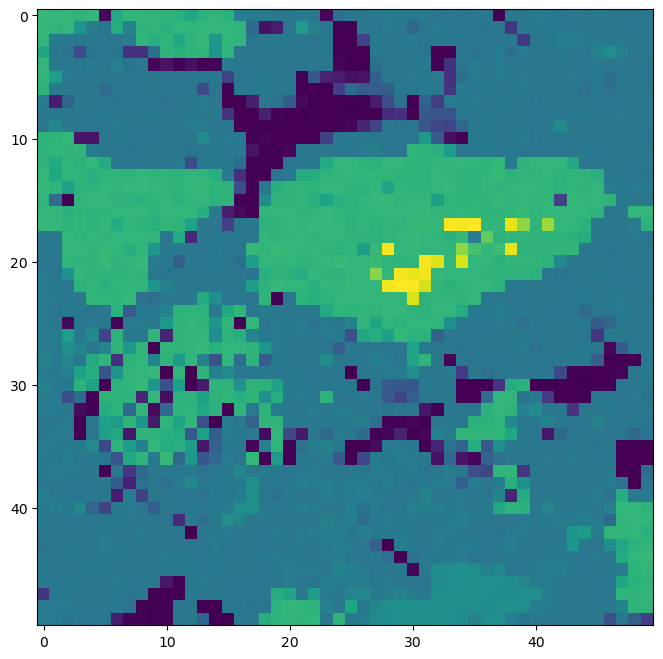

In [32]:
resized = cv2.resize(al_map.xray_data_scaled, (50, 50),cv2.INTER_CUBIC)
plt.imshow(resized)

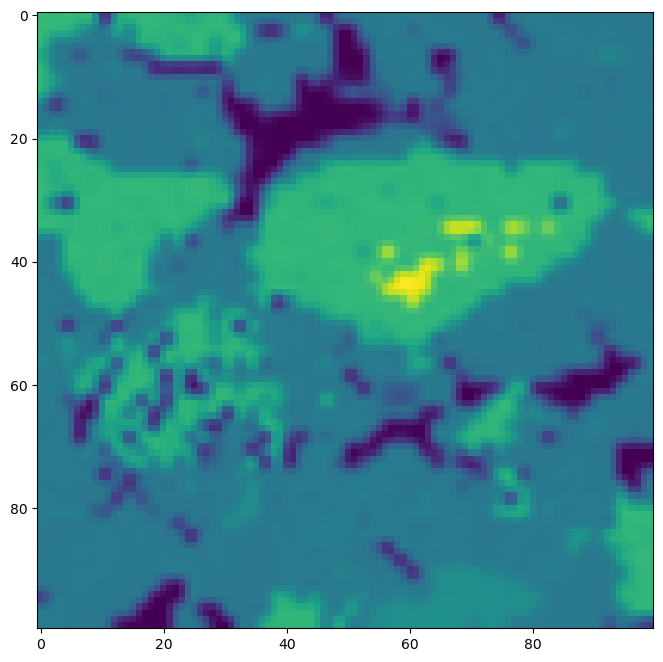

In [25]:
resized_up = cv2.resize(resized, (100, 100),cv2.INTER_CUBIC)
plt.imshow(resized_up)

In [24]:
resized.shape

(50, 50)